In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_46829/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
tsunami_ac_vars = [
    "vill_road_coverage",
    "vill_rwh_coverage",
    "vill_elec_mt_12_ratio",
    "road_pop_coverage",
    "bc_per_10k_pop",
    "branch_per_10k_pop",
    "shg_per_1000_hh",
    "pmuy_ratio",
    "irrigation_ratio",
    "jobcard_issued_ratio",
    "active_jobcard_ratio",
    "hh_non_farm_ratio" ]

In [3]:
import pandas as pd

# ID columns for reference
id_cols = ["state_code", "district_code", "block_code", "FID_Key"]

# Combine ID cols + chosen AC vars
tsunami_ac_cols = id_cols + tsunami_ac_vars

# Subset your main DataFrame
tsunami_ac_df = df[tsunami_ac_cols].copy()

# Check for missing
print(tsunami_ac_df.isna().sum())


state_code               0
district_code            0
block_code               0
FID_Key                  0
vill_road_coverage       0
vill_rwh_coverage        0
vill_elec_mt_12_ratio    0
road_pop_coverage        0
bc_per_10k_pop           0
branch_per_10k_pop       0
shg_per_1000_hh          0
pmuy_ratio               0
irrigation_ratio         0
jobcard_issued_ratio     0
active_jobcard_ratio     0
hh_non_farm_ratio        0
dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Only scale the adaptive capacity columns
features_only = tsunami_ac_df[tsunami_ac_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create scaled DataFrame
acap_scaled = pd.DataFrame(features_scaled, 
                           columns=tsunami_ac_vars, 
                           index=tsunami_ac_df.index)

# Attach scaled columns
for col in tsunami_ac_vars:
    tsunami_ac_df[col + "_scaled"] = acap_scaled[col]


In [5]:
from sklearn.decomposition import PCA
import numpy as np

acap_pca_vars = [c for c in tsunami_ac_df.columns if c.endswith("_scaled")]
X_acap = tsunami_ac_df[acap_pca_vars].astype(float)

pca = PCA()
pca.fit(X_acap)

# Summarize variance
pcaSummary_tsunami_ac = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print("\nPCA Variance Summary (Tsunami Adaptive Capacity):")
print(pcaSummary_tsunami_ac.round(3))



PCA Variance Summary (Tsunami Adaptive Capacity):
    % variance  Cumulative %
0        0.753         0.753
1        0.067         0.820
2        0.052         0.872
3        0.043         0.916
4        0.024         0.940
5        0.017         0.957
6        0.012         0.970
7        0.011         0.981
8        0.010         0.991
9        0.006         0.996
10       0.003         0.999
11       0.001         1.000


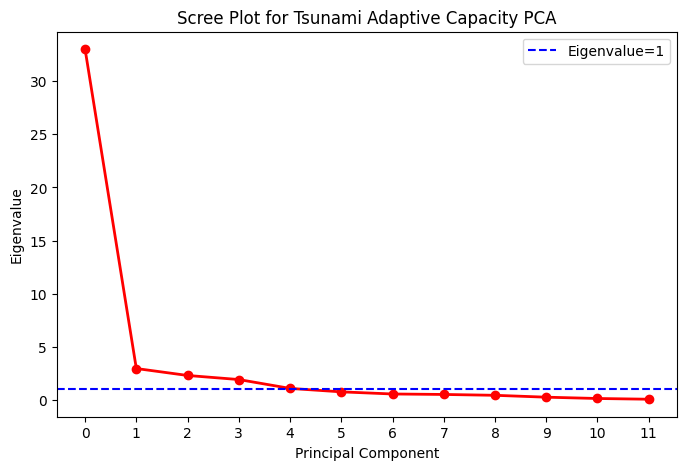

In [6]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Tsunami Adaptive Capacity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [7]:
n_components = 4
pca_n = PCA(n_components=n_components)
X_acap_pca = pca_n.fit_transform(X_acap)

pca_weights = pcaSummary_tsunami_ac['% variance'][:n_components]

for i in range(n_components):
    tsunami_ac_df[f"TsunAC_PC{i+1}"] = X_acap_pca[:, i]

# Weighted sum => "Tsunami_AdaptiveCap_Index"
tsunami_ac_df["Tsunami_AdaptiveCap_Index"] = 0
for i in range(n_components):
    tsunami_ac_df["Tsunami_AdaptiveCap_Index"] += (
        pca_weights.iloc[i] * tsunami_ac_df[f"TsunAC_PC{i+1}"]
    )

print("\nHead of final DataFrame with Tsunami Adaptive Capacity Index:")
print(tsunami_ac_df[["block_code", "Tsunami_AdaptiveCap_Index"]].head())
print("\nStats Summary of Tsunami_AdaptiveCap_Index:")
print(tsunami_ac_df["Tsunami_AdaptiveCap_Index"].describe())



Head of final DataFrame with Tsunami Adaptive Capacity Index:
   block_code  Tsunami_AdaptiveCap_Index
0        6498                  -0.001244
1        6492                  -0.975323
2        4689                   2.799880
3        4690                  -0.553005
4        4692                  -0.277094

Stats Summary of Tsunami_AdaptiveCap_Index:
count    5.815000e+03
mean     7.820247e-17
std      4.329280e+00
min     -1.837481e+00
25%     -8.532428e-01
50%     -5.498630e-01
75%     -7.368340e-02
max      2.094578e+02
Name: Tsunami_AdaptiveCap_Index, dtype: float64


In [8]:
loadings_ac = pd.DataFrame(
    pca_n.components_.T,
    index=acap_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

print("\nLoadings (Tsunami AC PCA):")
print(loadings_ac)



Loadings (Tsunami AC PCA):
                                   PC1       PC2       PC3       PC4
vill_road_coverage_scaled     0.010607 -0.313748  0.012892  0.007680
vill_rwh_coverage_scaled      0.003744 -0.157756  0.009155  0.038777
vill_elec_mt_12_ratio_scaled -0.011229  0.786926 -0.355122 -0.274802
road_pop_coverage_scaled      0.012216 -0.278154  0.006302 -0.004223
bc_per_10k_pop_scaled         0.454146  0.196125  0.778681 -0.350603
branch_per_10k_pop_scaled     0.890252 -0.080039 -0.398894  0.172972
shg_per_1000_hh_scaled       -0.004563  0.073098  0.021028  0.191812
pmuy_ratio_scaled            -0.010660  0.029179  0.123895  0.008210
irrigation_ratio_scaled      -0.009787 -0.097857  0.054338 -0.154491
jobcard_issued_ratio_scaled   0.001364  0.235887  0.225209  0.622153
active_jobcard_ratio_scaled   0.006156  0.200704  0.172525  0.554210
hh_non_farm_ratio_scaled      0.023050 -0.153251 -0.094392 -0.122929
